In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import json
from pandas.io.json import json_normalize
import os

from FCPython import createPitch

In [1]:
def get_competition_id(competition_name):
    # Open competitions data
    with open('../../SoccermaticsForPython/Statsbomb/data/competitions.json') as f:
        competitions = json.load(f)

    for comp in competitions:
        if comp['competition_name'] == competition_name:
            competition_id = comp["competition_id"]
            print(f'Competition id is: {competition_id}')
    
    return competition_id


def get_match_data_for_competition(competition_id):
    match_data = list()
    for root, dirs, files in os.walk(f'../../SoccermaticsForPython/Statsbomb/data/matches/{competition_id}'):
        for file in files:
            with open(root + '/'  + file) as f:
                match_data.append(json.load(f))
                print(f'Loaded match data for competition id {competition_id}')
    return match_data


def get_match_data_for_team(competition_match_data, team_to_get_data_for):
    match_ids_for_team = list()
    match_data_for_team = dict()
    for match in competition_match_data[0]:
        if match['away_team']['away_team_name'] == team_to_get_data_for or match['home_team']['home_team_name'] == team_to_get_data_for:
            match_ids_for_team.append(match['match_id'])
    print(f'Match ids for team: {", ".join([str(x) for x in match_ids_for_team])}')

    for match_id in match_ids_for_team:
        try:
            with open(f'../../SoccermaticsForPython/Statsbomb/data/events/{match_id}.json', encoding="utf8") as f:
                match_df = json_normalize(json.load(f), sep = "_").assign(match_id = match_id)
                opposition_team = np.setdiff1d(match_df['team_name'].unique(), np.array([team_name]))[0]
                match_data_for_team[f'{match_id}: {opposition_team}'] = (match_df)
                print(f'Loaded data for match with id {match_id}')
        except:
            print(f'Data load for match with id {match_id} FAILED')
    
    return match_data_for_team


def get_match_data_for_team_in_competition(competition_name, team_name):
    competition_id = get_competition_id(competition_name)
    competition_match_data = get_match_data_for_competition(competition_id)
    match_data_for_team = get_match_data_for_team(competition_match_data, team_name)
    
    return match_data_for_team

In [4]:
def get_pass_data_for_player(match_data_for_team, player_to_plot):
    pass_data_for_player = dict()
    for match_key, match_data in match_data_for_team.items():
        pass_fields = ['location', 'match_id', 'minute', 'pass_angle', 'pass_body_part_name',
                       'pass_end_location', 'pass_goal_assist', 'pass_height_name', 'pass_length',
                       'pass_recipient_name', 'pass_shot_assist', 'pass_type_name', 'period',
                       'player_name', 'possession_team_name', 'type_name', 'pass_through_ball']
        pass_fields_in_df = [x for x in pass_fields if x in match_data.columns]
        passes = match_data[match_data['type_name'] == 'Pass'][pass_fields_in_df]
        if player_to_plot in passes['player_name'].unique():
            player_pass_data = passes[passes['player_name'] == player_to_plot]
            pass_data_for_player[match_key] = player_pass_data
        
    return pass_data_for_player

In [9]:
def plot_match_shot_map(player_name, opposition_name, pass_data_for_player_for_match, pitch_length=120, pitch_width=80, 
                        circle_radius=0.8, arrow_width=0.4):
    
    mpl.rcParams["figure.facecolor"] = '#1d8b4c'
    mpl.rcParams["axes.facecolor"] = '#1d8b4c'
    mpl.rcParams["savefig.facecolor"] = '#1d8b4c'
    
    fig, ax = createPitch(pitch_length, pitch_width, 'yards', 'white')

    for i, player_pass in pass_data_for_player_for_match.iterrows():
        x_start = player_pass['location'][0]
        y_start = pitch_width - player_pass['location'][1]
        x_end = player_pass['pass_end_location'][0]
        y_end = pitch_width - player_pass['pass_end_location'][1]
        dx = x_end - x_start
        dy = y_end - y_start
        
        pass_type_color_dict = {
            'pass': 'gold',
            'shot_assist': 'orange',
            'goal_assist': 'red'
        }
        arrow_color = pass_type_color_dict['pass']
        arrow_alpha = 0.4
        for pass_type, color in pass_type_color_dict.items():
            if f'pass_{pass_type}' in player_pass.index:
                if player_pass[f'pass_{pass_type}'] == True:
                    arrow_color = color
                    arrow_alpha = 0.9
                    
        pass_start_circle = plt.Circle((x_start, y_start), radius=circle_radius, color=arrow_color, alpha=0.2)
        ax.add_patch(pass_start_circle)

        pass_arrow = plt.arrow(x_start, y_start, dx, dy, width=arrow_width, color=arrow_color, alpha=arrow_alpha,
                               head_width=arrow_width*4, head_length=arrow_width*4)
        ax.add_patch(pass_arrow)

    fig.set_size_inches(10, 7)
    plt.title(f'Pass map for {player_name} against {opposition_name}')
    
    # Here we create a legend:
    # we'll plot empty lists with the desired size and label
    for pass_type, color in pass_type_color_dict.items():
        plt.scatter([], [], c=color, s=30, alpha=0.8, label=pass_type.replace('_', ' '))
    plt.legend(scatterpoints=1, loc=(0.05, 0.08), labelspacing=1, title='Pass types')

    # If folder doesn't exist, then create it.
    if not os.path.isdir('Outputs'):
        os.makedirs('Outputs')
    
    fig.savefig(f'Output/passes{opposition_name}.jpg', facecolor=fig.get_facecolor(), dpi=300) 
    plt.show()
    plt.close()

In [6]:
competition_name = 'FIFA World Cup'
team_name = 'Croatia'
match_data_for_team = get_match_data_for_team_in_competition(competition_name, team_name)

print(match_data_for_team.keys())

Competition id is: 43
Loaded match data for competition id 43
Match ids for team: 7581, 7529, 7545, 8652, 7561, 8658, 8656
Loaded data for match with id 7581
Loaded data for match with id 7529
Loaded data for match with id 7545
Loaded data for match with id 8652
Loaded data for match with id 7561
Loaded data for match with id 8658
Loaded data for match with id 8656
dict_keys(['7581: Denmark', '7529: Nigeria', '7545: Argentina', '8652: Russia', '7561: Iceland', '8658: France', '8656: England'])


In [77]:
# for m_id, m_data in match_data_for_team.items():
#     print(m_data['player_name'].unique())

In [7]:
player_to_plot = 'Luka Modrić'
pass_data_for_player = get_pass_data_for_player(match_data_for_team, player_to_plot)

print(pass_data_for_player.keys())

dict_keys(['7581: Denmark', '7529: Nigeria', '7545: Argentina', '8652: Russia', '7561: Iceland', '8658: France', '8656: England'])


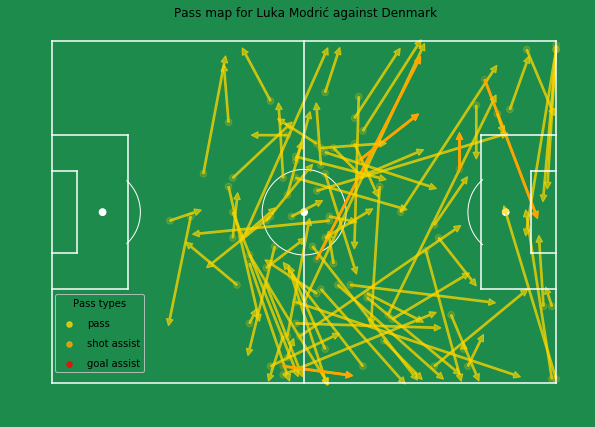

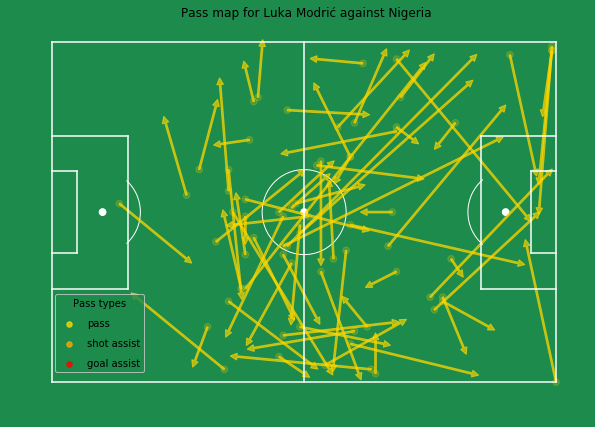

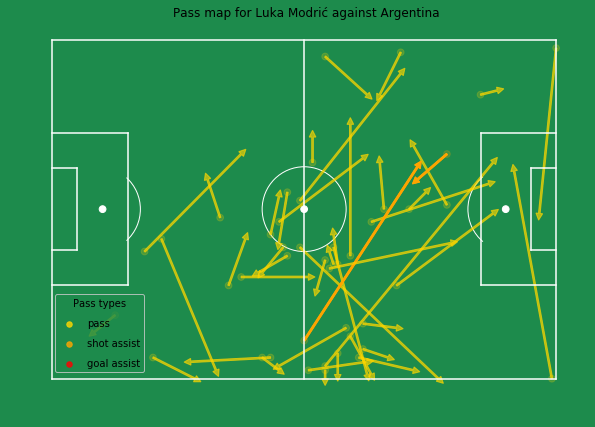

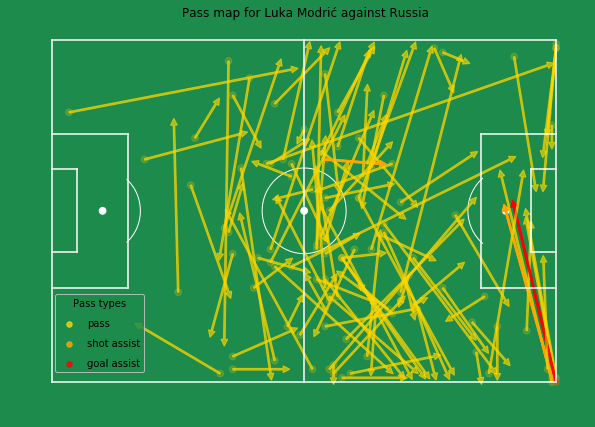

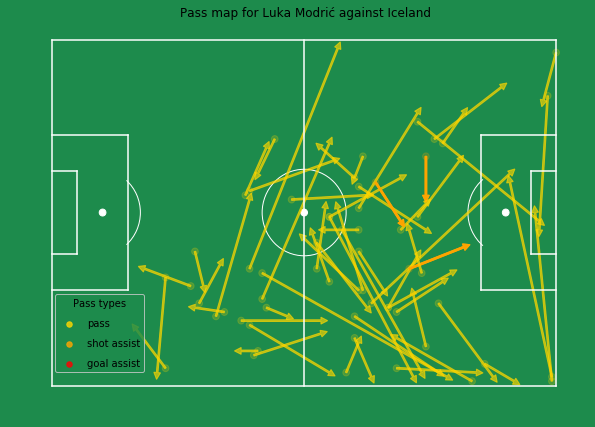

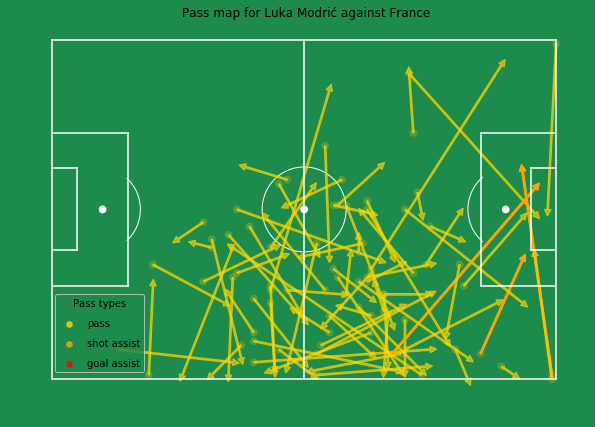

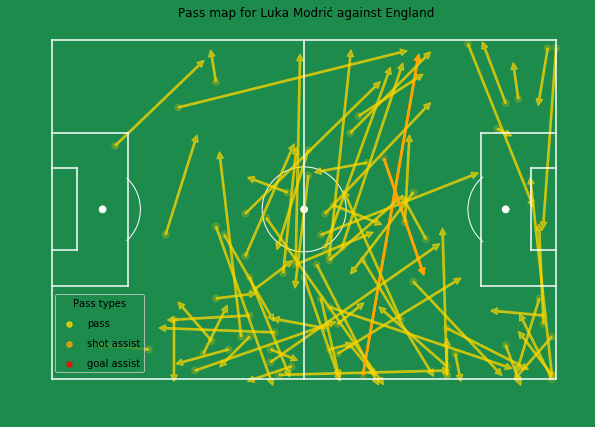

In [11]:
for match_key, match_data in pass_data_for_player.items():
    opposition_name = match_key[6:]
    plot_match_shot_map(player_to_plot, opposition_name, match_data)

In [12]:
total_passes = 0

for match_key, match_data in pass_data_for_player.items():
    passes_in_match = len(match_data)
    print(f'{str(passes_in_match)} passes against {match_key[6:]}')
    total_passes += passes_in_match
    
print(f'A total of {total_passes} passes in the tournament')

91 passes against Denmark
69 passes against Nigeria
44 passes against Argentina
110 passes against Russia
58 passes against Iceland
77 passes against France
78 passes against England
A total of 527 passes in the tournament
